#### Bag of Words Approaches:
- In this notebook I use bag of words (BoW) type of text vectorization. 
- Validation set is balanced in the same propotrion as the train set. 
- Evaluation metrics are: AUC and F1 score. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


# sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import l1_min_c

from numpy import array
from scipy.sparse import csr_matrix
from time import time
import re
import string


# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.utils import to_categorical

/home/elena/anaconda3/envs/default/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/elena/anaconda3/envs/default/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/elena/anaconda3/envs/default/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/elena/anaconda3/envs/default/lib/python3

In [3]:
df_train = pd.read_pickle('train_prepared.pkl')
df_valid = pd.read_pickle('valid_prepared_balanced.pkl')
print(len(df_train))
print(len(df_valid))

4832
1176


####  CountVectorizer from scikit-learn package simply counts how many times each word occurs in the note. There is also a TfidfVectorizer which takes into account how often words are used across all notes, that I use later.

In [4]:
vocabulary_size = 20000

In [5]:
vect = CountVectorizer(max_features = 50000)
vect.fit(df_train.TEXT.values)
X_train_tf = vect.transform(df_train.TEXT.values)

#### Finding most frequent words to use them as Stop-Words:¶

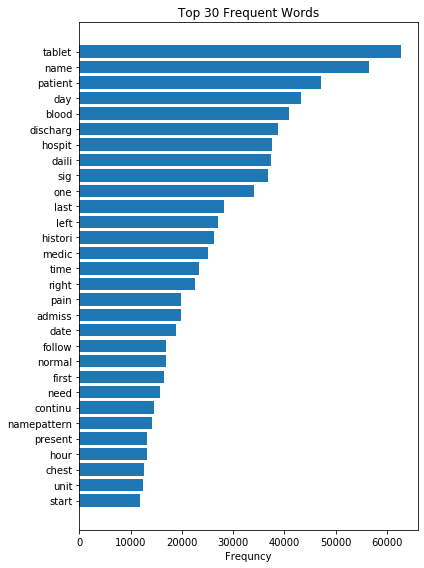

In [6]:
sum_words = X_train_tf.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq_plot = words_freq[:30]
values = [value[0] for value in words_freq_plot]
freq = [value[1] for value in words_freq_plot]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,8), sharex=True)
plt.barh(range(len(values)),freq, align = 'center')
plt.yticks(range(len(values)),values)
plt.title("Top 30 Frequent Words")
plt.gca().invert_yaxis()
plt.xlabel('Frequncy')
plt.tight_layout()
plt.show()

#### We can see the most frequent words. Now we can make our own stop words:

In [7]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                 'from','there','an','that','p','are','have','has','h','but','o',
                 'namepattern','which','every','also', 'day']

### Making BoW using the TEXT column:

In [8]:
vect = CountVectorizer(max_features = 50000,  
                       stop_words = my_stop_words)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=50000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
from sklearn import preprocessing
from sklearn import svm

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

# Response:

y_train_labels = df_train.OUTPUT_LABEL
y_valid_labels = df_valid.OUTPUT_LABEL


le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
y_train=np.array(le.transform(y_train_labels))


le.fit(y_valid_labels)
y_valid=np.array(le.transform(y_valid_labels))

print(y_train[:10])
print(y_train.shape)
print(X_train_tf.shape)
print(X_valid_tf.shape)
print('valid shape ', y_valid.shape)

[1 1 0 0 0 0 1 0 0 0]
(4832,)
(4832, 31059)
(1176, 31059)
valid shape  (1176,)


In [11]:
Model = []
AUC = []
F1 = []

### Logistic Regression for BoW:

In [12]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
print(auc)
y_valid_preds = clf.predict(X_valid_tf)

f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.710814938220186
0.6655484230443313


In [14]:
Model.append("LR on BoW")
AUC.append(auc)
F1.append(f_score_macro)

### SVM on BOW 

#### Previously, I did grid-search over SVM parameters and obtaines gamma=0.001 and C=1

In [15]:
from sklearn.feature_selection import mutual_info_classif
num_features = 20000
clf_train = Pipeline(
    [  ("filter", SelectKBest(mutual_info_classif, k=num_features)),
       ("classification", svm.SVC(kernel="rbf", gamma=0.001, C=1, probability=True)),
    ]
)

clf_train.fit(X_train_tf, y_train)

Pipeline(memory=None,
         steps=[('filter',
                 SelectKBest(k=20000,
                             score_func=<function mutual_info_classif at 0x7f6343dbecb0>)),
                ('classification',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [16]:
y_valid_preds = clf_train.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
print(auc)
y_valid_preds = clf_train.predict(X_valid_tf)
f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.7148670692766902
0.6594806011151594


In [17]:
Model.append("SVM on BoW")
AUC.append(auc)
F1.append(f_score_macro)

### Linear SVM on BoW

In [18]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5, C=10)
clf.fit(X_train_tf, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [19]:
y_valid_preds = clf.predict(X_valid_tf)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
print(auc)
y_valid_preds = clf.predict(X_valid_tf)

f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.5833333333333333
0.5832742735648477


In [20]:
Model.append("Linear SVM on BoW")
AUC.append(auc)
F1.append(f_score_macro)

### Stochastic Gradient Descent¶

In [21]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
y_valid_preds = clf.predict(X_valid_tf)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
print(auc)

y_valid_preds = clf.predict(X_valid_tf)

f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.6156462585034014
0.6148932963937542


In [23]:
Model.append("SGD on BoW")
AUC.append(auc)
F1.append(f_score_macro)

### Naive Bayes (NB) on BoW:

In [24]:
X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()

In [25]:
gnb = GaussianNB()
clf = gnb.fit(X_train_Array, y_train)

y_valid_preds = clf.predict_proba(X_valid_Array) 
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds[:,1])
auc = metrics.auc(fpr,tpr)

print(auc)

y_valid_preds = clf.predict(X_valid_tf.todense())

f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.5258254662409182
0.5186873771337993


In [26]:
Model.append("NB on BoW")
AUC.append(auc)
F1.append(f_score_macro)

## TF-IDF Vectorizing

In [27]:
vect_TF_IDF = TfidfVectorizer(stop_words = my_stop_words)
vect_TF_IDF.fit(df_train.TEXT.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [28]:
X_train_tf_IDF = vect_TF_IDF.transform(df_train.TEXT.values)
X_valid_tf_IDF = vect_TF_IDF.transform(df_valid.TEXT.values)

### Logistic Regression with TF_IDF for BoW :

In [29]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf_IDF, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_valid_preds_TF_IDF = clf.predict_proba(X_valid_tf_IDF)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds_TF_IDF)
auc = metrics.auc(fpr,tpr)
print(auc)

y_valid_preds = clf.predict(X_valid_tf_IDF.todense())
f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.6807956175667546
0.6309139505015793


In [31]:
Model.append("LR on TF-IDF of BoW")
AUC.append(auc)
F1.append(f_score_macro)

### SVM with TF-IDF

In [32]:
from sklearn import svm
from sklearn.svm import SVC

In [33]:
from sklearn.feature_selection import mutual_info_classif
num_features = 20000
clf_train = Pipeline(
    [  ("filter", SelectKBest(mutual_info_classif, k=num_features)),
       ("classification", svm.SVC(kernel="rbf", gamma=0.001, C=10, probability=True)),
    ]
)

clf_train.fit(X_train_tf_IDF, y_train)

Pipeline(memory=None,
         steps=[('filter',
                 SelectKBest(k=20000,
                             score_func=<function mutual_info_classif at 0x7f6343dbecb0>)),
                ('classification',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.001, kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [34]:
y_valid_preds_TF_IDF = clf_train.predict_proba(X_valid_tf_IDF)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds_TF_IDF)
auc = metrics.auc(fpr,tpr)
print(auc)

y_valid_preds = clf_train.predict(X_valid_tf_IDF.todense())
f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.6832685455134435
0.6374520559841368


In [35]:
Model.append("SVM on TF-IDF of BoW")
AUC.append(auc)
F1.append(f_score_macro)

### Neural Networks on BoW :
#### Here I am using a simple one layer neural network to see if I can get a better result than LR model.

In [36]:
y_train_binary = to_categorical(y_train)
y_valid_binary = to_categorical(y_valid)
print(y_train_binary[:3])
X_train_Array = X_train_tf.todense()
X_valid_Array = X_valid_tf.todense()

[[0. 1.]
 [0. 1.]
 [1. 0.]]


#### In the NN model I changed some things. I put binary entropy instead of categorical, because we deal with binary class. I added earlystopping wich saves time of training, the training stops when the validation loss no changes duroing five steps, and checkpointer to save the best model. 

In [37]:
model = Sequential()
model.add(Dense(500, input_dim = X_train_tf.shape[1] , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer=Adam(0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import h5py

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'modelNN.{epoch:02d}-{val_loss:.6f}.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)
history = model.fit(X_train_Array, y_train, 
                    epochs=500, batch_size=1024, 
                    callbacks=[earlystopper, checkpointer, reduce_lr], 
                    validation_data=(X_valid_Array, y_valid))
history

Instructions for updating:
Use tf.cast instead.
Train on 4832 samples, validate on 1176 samples
Epoch 1/500
4832/4832 [==============================] - 3s 637us/step - loss: 0.7055 - acc: 0.5203 - val_loss: 0.6707 - val_acc: 0.5833

Epoch 00001: val_loss improved from inf to 0.67065, saving model to modelNN.01-0.670652.hdf5
Epoch 2/500
4832/4832 [==============================] - 2s 461us/step - loss: 0.6785 - acc: 0.5660 - val_loss: 0.6591 - val_acc: 0.6088

Epoch 00002: val_loss improved from 0.67065 to 0.65909, saving model to modelNN.02-0.659092.hdf5
Epoch 3/500
4832/4832 [==============================] - 2s 473us/step - loss: 0.6596 - acc: 0.6134 - val_loss: 0.6494 - val_acc: 0.6420

Epoch 00003: val_loss improved from 0.65909 to 0.64943, saving model to modelNN.03-0.649429.hdf5
Epoch 4/500
4832/4832 [==============================] - 2s 450us/step - loss: 0.6429 - acc: 0.6387 - val_loss: 0.6437 - val_acc: 0.6454

Epoch 00004: val_loss improved from 0.64943 to 0.64368, saving mo

In [39]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


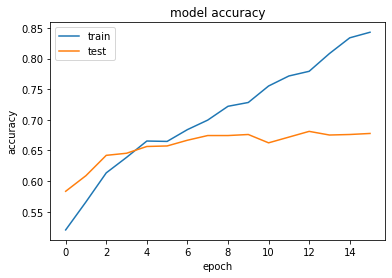

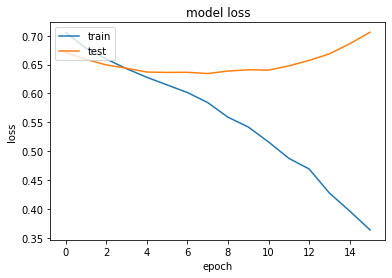

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
y_pred = model.predict_proba(X_valid_Array)
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_pred)
auc = metrics.auc(fpr,tpr)
print(auc)

y_pred = model.predict(X_valid_Array)
print(y_pred.shape)
y_pred1 = y_pred
print(y_pred1.shape)
print(y_pred1[:10])
f_score_macro = metrics.f1_score(y_valid, y_pred.round(), average='macro')
print(f_score_macro)

0.7151591929288721
(1176, 1)
(1176, 1)
[[0.1446177 ]
 [0.85865575]
 [0.76957595]
 [0.01929906]
 [0.9233078 ]
 [0.70209014]
 [0.24846306]
 [0.83641183]
 [0.98229194]
 [0.5495217 ]]
0.677636941592562


In [42]:
model.save('NN_model')

In [43]:
model = load_model('NN_model')

In [44]:
Model.append("NN on BoW")
AUC.append(auc)
F1.append(f_score_macro)

In [45]:
print(Model)
print(AUC)
print(F1)

['LR on BoW', 'SVM on BoW', 'Linear SVM on BoW', 'SGD on BoW', 'NB on BoW', 'LR on TF-IDF of BoW', 'SVM on TF-IDF of BoW', 'NN on BoW']
[0.710814938220186, 0.7148670692766902, 0.5833333333333333, 0.6156462585034014, 0.5258254662409182, 0.6807956175667546, 0.6832685455134435, 0.7151591929288721]
[0.6655484230443313, 0.6594806011151594, 0.5832742735648477, 0.6148932963937542, 0.5186873771337993, 0.6309139505015793, 0.6374520559841368, 0.677636941592562]


## Tri-grams 

In [46]:
vect = CountVectorizer(max_features = 50000,  
                       stop_words = my_stop_words,
                       ngram_range= (1,3))
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=50000, min_df=1,
                ngram_range=(1, 3), preprocessor=None,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [47]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)


### Logistic Regression with ngrams:

In [48]:
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
y_valid_preds = clf.predict_proba(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds)
auc = metrics.auc(fpr,tpr)
print(auc)
y_valid_preds = clf.predict(X_valid_tf)
f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.7184448609375722
0.6699099402285111


In [50]:
Model.append("LR on BoW up to 3grams")
AUC.append(auc)
F1.append(f_score_macro)

### Linear SVM with n-grams

In [51]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5, C=10)
clf.fit(X_train_tf, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [52]:
y_valid_preds = clf._predict_proba_lr(X_valid_tf)[:, 1]
fpr, tpr, _ = metrics.roc_curve(np.array(y_valid), y_valid_preds_TF_IDF)
auc = metrics.auc(fpr,tpr)
print(auc)

y_valid_preds = clf.predict(X_valid_tf)
f_score_macro = metrics.f1_score(y_valid, y_valid_preds, average='macro')
print(f_score_macro)

0.6832685455134435
0.598545404049609


In [53]:
Model.append("Linear SVM on 3grams")
AUC.append(auc)
F1.append(f_score_macro)

In [54]:
Results = pd.DataFrame({'Model': Model, 'AUC': AUC, 'F1 macro': F1})

### Comparing results of different models:

In [55]:
Results.to_pickle('AUC_Models_BoW_valid_balanced.pkl')
Results.to_csv('AUC_F1_Models_preformance_valid_balanced.csv', index=False)
Results

,Model,AUC,F1 macro
0,LR on BoW,0.710815,0.665548
1,SVM on BoW,0.714867,0.659481
2,Linear SVM on BoW,0.583333,0.583274
3,SGD on BoW,0.615646,0.614893
4,NB on BoW,0.525825,0.518687
5,LR on TF-IDF of BoW,0.680796,0.630914
6,SVM on TF-IDF of BoW,0.683269,0.637452
7,NN on BoW,0.715159,0.677637
8,LR on BoW up to 3grams,0.718445,0.669910
9,Linear SVM on 3grams,0.683269,0.598545


### Conclusions:
- Performance depends on the class distribution both in training and validation sets. 
- Neural Network shows the best result.
- SVMs and Logistic regression always give good result on small datasets. 
- N-grams may show better performance. 
- Naive Bayes never performs well on unstructured texts. 



    